In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

In [56]:
import trieste
from trieste.utils.objectives import branin
from util.plotting_plotly import plot_function_plotly
from util.plotting import plot_function_2d, plot_bo_points
from trieste.models import create_model

search_space = trieste.space.Box([0, 0], [1, 1])

fig = plot_function_plotly(
    branin, search_space.lower, search_space.upper, grid_density=20
)
fig.update_layout(height=400, width=400)
fig.show()

In [4]:
from trieste.acquisition.rule import OBJECTIVE

observer = trieste.utils.objectives.mk_observer(branin, OBJECTIVE)

num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

In [66]:
initial_data

{'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(5, 2), dtype=float64, numpy=
 array([[0.74731156, 0.45715611],
        [0.71670308, 0.1830982 ],
        [0.37016942, 0.98365795],
        [0.00584848, 0.15572476],
        [0.66973948, 0.50211004]])>, observations=<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
 array([[ 52.74206955],
        [ 20.91833473],
        [110.23393455],
        [225.05283879],
        [ 52.49971937]])>)}

In [16]:
import gpflow

def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return {OBJECTIVE: {
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    }}

model = build_model(initial_data[OBJECTIVE])

In [6]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
result = bo.optimize(1, initial_data, model)
dataset = result.try_get_final_datasets()[OBJECTIVE]
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

Optimization completed without errors
query point: [9.99999780e-01 3.77741669e-07]
observation: [10.96081812]


TypeError: colorbar() missing 1 required positional argument: 'mappable'

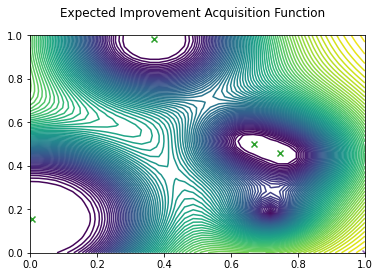

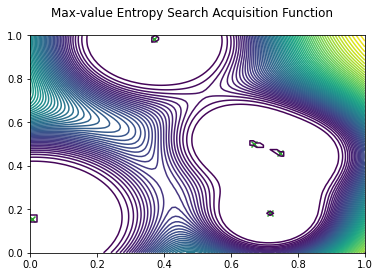

In [60]:
# %% [markdown]
# # Try an alternative acquisition function

# %% [markdown]
# By default, Trieste uses Expected Improvement (EI) as its acqusition function when performing Bayesian optimization. However, many alternative acqusition functions have been developed. One such alternative is Min-value Entropy Search (MES), which approximates the distribution of current estimate of the global minimum and tries to decrease its entropy with each optimization step.

# %% [markdown]
# We plot these two acquisition functions across our search space. Areas with high acquisition function scores (i.e bright regions) are those rated as promising locations for the next evaluation of our objective function. We see that EI wishes to continue exploring the search space, whereas MES wants to focus resources on evaluating a specific region.

# %%


mins = [0.0, 0.0]
maxs = [1.0, 1.0]





model_spec = {tag: create_model(spec) for tag, spec in model.items()}
mes = trieste.acquisition.MinValueEntropySearch(
    search_space, num_samples=5, grid_size=5000
)
ei = trieste.acquisition.ExpectedImprovement()
ei_acq_function = ei.using(OBJECTIVE).prepare_acquisition_function(initial_data, model_spec)
mes_acq_function = mes.using(OBJECTIVE).prepare_acquisition_function(initial_data, model_spec)

fig, ax = plot_function_2d(ei_acq_function, mins, maxs, grid_density=40, contour=True)
plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)
fig.suptitle("Expected Improvement Acquisition Function")

fig, ax = plot_function_2d(mes_acq_function, mins, maxs, grid_density=100, contour=True)
plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)
fig.suptitle("Max-value Entropy Search Acquisition Function")



In [71]:
ei_acq_function(initial_data[OBJECTIVE].query_points)

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.        ],
       [0.00126157],
       [0.        ],
       [0.        ],
       [0.        ]])>

In [62]:
model = build_model(initial_data[OBJECTIVE])
acq_rule = trieste.acquisition.rule.EfficientGlobalOptimization(mes.using(OBJECTIVE))

# %% [markdown]
# All that remains is to run the whole BO loop for 15 steps.

# %%
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result_mes = bo.optimize(5, initial_data, model, acq_rule)


Optimization completed without errors


In [63]:
result_mes

OptimizationResult(final_result=Ok(Record(datasets={'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(10, 2), dtype=float64, numpy=
array([[7.47311560e-01, 4.57156106e-01],
       [7.16703076e-01, 1.83098196e-01],
       [3.70169415e-01, 9.83657947e-01],
       [5.84848284e-03, 1.55724765e-01],
       [6.69739483e-01, 5.02110045e-01],
       [9.99429716e-01, 9.99361178e-01],
       [9.99986297e-01, 6.43269540e-06],
       [5.72970252e-01, 5.22216215e-07],
       [4.19212714e-01, 2.79987903e-01],
       [4.14969898e-01, 1.34663117e-08]])>, observations=<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[ 52.74206955],
       [ 20.91833473],
       [110.23393455],
       [225.05283879],
       [ 52.49971937],
       [145.80129477],
       [ 10.95801138],
       [  5.1618948 ],
       [ 12.67890609],
       [ 31.27687589]])>)}, models={'OBJECTIVE': GaussianProcessRegression(<gpflow.models.gpr.GPR object at 0x7fc16c7826d0>, Optimizer(optimizer=<gpflow.optimizers.scipy.Scipy object 

In [ ]:
# %% [markdown]
# Copyright 2020 The Trieste Contributors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# %% [markdown]
# # Introduction

# %%
from dataclasses import astuple

import gpflow
from gpflow.utilities import print_summary, set_trainable
import numpy as np
import tensorflow as tf

import trieste
from trieste.bayesian_optimizer import OptimizationResult
from trieste.utils.objectives import branin, mk_observer
from trieste.acquisition.rule import OBJECTIVE

from util.plotting_plotly import (
    plot_function_plotly, plot_gp_plotly, add_bo_points_plotly
)
from util.plotting import plot_function_2d, plot_bo_points, plot_regret

# %%
gpflow.config.set_default_float(np.float64)
np.random.seed(1793)
tf.random.set_seed(1793)

# %% [markdown]
# ## Describe the problem
# In this example, we look to find the minimum value of the two-dimensional Branin function over the hypercube $[0, 1]^2$. We can plot contours of the Branin over this space.

# %%
mins = [0.0, 0.0]
maxs = [1.0, 1.0]

fig = plot_function_plotly(branin, mins, maxs, grid_density=20)
fig.update_layout(height=400, width=400)
fig.show()

# %% [markdown]
# ## Sample the observer over the search space
#
# Sometimes we don't have direct access to the objective function. We only have an observer that indirectly observes it. In _Trieste_, the observer outputs a number of datasets, each of which must be labelled so the optimization process knows which is which. In our case, we only have one dataset, the objective. We'll use _Trieste_'s default label for single-model setups, `OBJECTIVE`. We can convert a function with `branin`'s signature to a single-output observer using `mk_observer`.
#
# The optimization procedure will benefit from having some starting data from the objective function to base its search on. We sample five points from the search space and evaluate them on the observer. We can represent the search space using a `Box`.

# %%
observer = mk_observer(branin, OBJECTIVE)
lower_bound = tf.cast(mins, gpflow.default_float())
upper_bound = tf.cast(maxs, gpflow.default_float())
search_space = trieste.space.Box(lower_bound, upper_bound)

num_initial_points = 5
initial_query_points = search_space.sample(num_initial_points)
initial_data = observer(initial_query_points)

# %% [markdown]
# ## Model the objective function
#
# The Bayesian optimization procedure estimates the next best points to query by using a probabilistic model of the objective. We'll use Gaussian process regression for this, provided by GPflow. The model will need to be trained on each step as more points are evaluated, so we'll package it with GPflow's Scipy optimizer.
#
# Note we could leave it to the optimizer to build this model, but we'll want to inspect it later so we'll build it ourselves.
#
# Just like the data output by the observer, the optimization process assumes multiple models, so we'll need to label the model in the same way.

# %%
def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=0.2 * np.ones(2,))
    gpr = gpflow.models.GPR(astuple(data), kernel, noise_variance=1e-5)
    set_trainable(gpr.likelihood, False)

    return {OBJECTIVE: trieste.models.create_model({
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {"options": dict(maxiter=100)},
    })}

model = build_model(initial_data[OBJECTIVE])

# %% [markdown]
# ## Run the optimization loop
#
# We can now run the Bayesian optimization loop by defining a `BayesianOptimizer` and calling its `optimize` method.
#
# The optimizer uses an acquisition rule to choose where in the search space to try on each optimization step. We'll use the default acquisition rule, which is Efficient Global Optimization with Expected Improvement.
#
# We'll run the optimizer for fifteen steps.
#
# The `optimize` method returns several things (see the `optimize` documentation for details), but we're only interested in the data, which captures the points where the objective was queried and the resulting values. Note that the optimizer updates the model in place.
#
# However, since the optimization loop catches errors so as not to lose progress, we must check if any errors occurred so we know the data is valid. We'll do that crudely here by re-raising any such errors. You may wish instead to use the history to restore the process from an earlier point.

# %%
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result: OptimizationResult = bo.optimize(15, initial_data, model)

if result.error is not None: raise result.error

dataset = result.datasets[OBJECTIVE]

# %% [markdown]
# ## Explore the results
#
# We can now get the best point found by the optimizer. Note this isn't necessarily the point that was last evaluated.

# %%
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

arg_min_idx = tf.squeeze(tf.argmin(observations, axis=0))

print(f"query point: {query_points[arg_min_idx, :]}")
print(f"observation: {observations[arg_min_idx, :]}")

# %% [markdown]
# We can visualise how the optimizer performed by plotting all the acquired observations, along with the true function values and optima, either in a two-dimensional contour plot ...

# %%
_, ax = plot_function_2d(branin, mins, maxs, grid_density=30, contour=True)
plot_bo_points(query_points, ax[0, 0], num_initial_points, arg_min_idx)

# %% [markdown]
# ... or as a three-dimensional plot

# %%
fig = plot_function_plotly(branin, mins, maxs, grid_density=20)
fig.update_layout(height=500, width=500)

fig = add_bo_points_plotly(
    x=query_points[:, 0],
    y=query_points[:, 1],
    z=observations[:, 0],
    num_init=num_initial_points,
    idx_best=arg_min_idx,
    fig=fig,
)
fig.show()

# %% [markdown]
# We can also visualise the how each successive point compares the current best.
#
# We produce two plots. The left hand plot shows the observations (crosses and dots), the current best (orange line), and the start of the optimization loop (blue line). The right hand plot is the same as the previous two-dimensional contour plot, but without the resulting observations. The best point is shown in each (purple dot).

# %%
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2)
plot_regret(observations, ax[0], num_init=num_initial_points, idx_best=arg_min_idx)
plot_bo_points(query_points, ax[1], num_init=num_initial_points, idx_best=arg_min_idx)

# %% [markdown]
# We can visualise the model over the objective function by plotting the mean and 95% confidence intervals of its predictive distribution.

# %%
fig = plot_gp_plotly(model[OBJECTIVE].model, mins, maxs, grid_density=30)

fig = add_bo_points_plotly(
    x=query_points[:, 0],
    y=query_points[:, 1],
    z=observations[:, 0],
    num_init=num_initial_points,
    idx_best=arg_min_idx,
    fig=fig,
    figrow=1,
    figcol=1,
)

fig.show()

# %% [markdown]
# We can also inspect the model hyperparameters, and use the history to see how the length scales evolved over iterations

# %%
print_summary(model[OBJECTIVE].model)

ls_list = [
    step.models[OBJECTIVE].model.kernel.lengthscales.numpy()  # type: ignore
    for step in result.history
]

ls = np.array(ls_list)
plt.plot(ls[:, 0])
plt.plot(ls[:, 1])

# %% [markdown]
# ## Run the optimizer for more steps
#
# If we need more iterations for better convergence, we can run the optimizer again using the data produced from the last run, as well as the model. We'll visualise the final data.

# %%
result = bo.optimize(5, result.datasets, model)

if result.error is not None: raise result.error

dataset = result.datasets[OBJECTIVE]

arg_min_idx = tf.squeeze(tf.argmin(dataset.observations, axis=0))
fig, ax = plot_function_2d(branin, mins, maxs, grid_density=40, contour=True)

plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)

# %% [markdown]
# # Try an alternative acquisition function

# %% [markdown]
# By default, Trieste uses Expected Improvement (EI) as its acqusition function when performing Bayesian optimization. However, many alternative acqusition functions have been developed. One such alternative is Min-value Entropy Search (MES), which approximates the distribution of current estimate of the global minimum and tries to decrease its entropy with each optimization step.

# %% [markdown]
# We plot these two acquisition functions across our search space. Areas with high acquisition function scores (i.e bright regions) are those rated as promising locations for the next evaluation of our objective function. We see that EI wishes to continue exploring the search space, whereas MES wants to focus resources on evaluating a specific region.

# %%
mes = trieste.acquisition.MinValueEntropySearch(
    search_space, num_samples=5, grid_size=5000
)
ei = trieste.acquisition.ExpectedImprovement()
mes_acq_function = mes.using(OBJECTIVE).prepare_acquisition_function(initial_data, model)
ei_acq_function = ei.using(OBJECTIVE).prepare_acquisition_function(initial_data, model)

fig, ax = plot_function_2d(mes_acq_function, mins, maxs, grid_density=40, contour=True)
plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)
fig.suptitle("Max-value Entropy Search Acquisition Function")
fig, ax = plot_function_2d(ei_acq_function, mins, maxs, grid_density=40, contour=True)
plot_bo_points(
    dataset.query_points.numpy(),
    ax=ax[0, 0],
    num_init=len(dataset.query_points),
    idx_best=arg_min_idx,
)
fig.suptitle("Expected Improvement Acquisition Function")

# %% [markdown]
# To compare the performance of the optimization achieved by these two different acquisition functions, we re-run the above BO loop using MES. 

# %% [markdown]
# We re-initialize the model and define a new acquisiton rule.

# %%
model = build_model(initial_data[OBJECTIVE])
acq_rule = trieste.acquisition.rule.EfficientGlobalOptimization(mes.using(OBJECTIVE))

# %% [markdown]
# All that remains is to run the whole BO loop for 15 steps.

# %%
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result_mes: OptimizationResult = bo.optimize(20, initial_data, model, acq_rule)

if result_mes.error is not None: raise result_mes.error

dataset_mes = result_mes.datasets[OBJECTIVE]
mes_optimization_progress = np.minimum.accumulate(dataset_mes.observations)[5:]
ei_optimization_progress = np.minimum.accumulate(dataset.observations)[5:]

# %% [markdown]
# We can now plot the evolution of the best found objective function value as we increase the number of optimization steps. For this particular optimization task we see that EI provides more efficient initial optimization, however MES finds the global optimum faster.

# %%
plt.plot(mes_optimization_progress,label="MES")
plt.plot(ei_optimization_progress,label="EI")
plt.legend(fontsize=20)
plt.title("Performance of different acquisition functions")
plt.xlabel("# Optimization Steps")
plt.ylabel("Best objective function query")